<a href="https://colab.research.google.com/github/iu5git/MPPR/blob/main/notebooks/Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ONNX Cifar100 Practice

# Task

You need to get acquainted with the PyTorch machine learning framework and complete three tasks:
1. Train a fully connected neural network to classify 3 classes of images from the CIFAR100 data set according to the variant with an accuracy of at least 70% on the test sample.
For the task, you need to create your own CIFAR100 subsample according to the option.
2. Convert the model to ONNX and save locally.
3. Test the trained model on your images.
  * Download the directory with the html file and embed the file of the model trained on LR into it.
  * Download pictures from the Internet according to the option and open them in html using the button. The image is scaled automatically in the script.
  * Select the necessary classes for the finished model. Check the stability of a fully connected model by moving the picture.

The labs are run on the Google Colab platform - just follow the links at the beginning of the notebook. You can also work with laboratory notebooks locally.

The report should contain: a title page, a task with an option, screenshots and brief explanations for each stage of laboratory work.

# Options for the Task
You should use the following classes from CIFAR100:
1. Group number
2. Option number
3. Option number + 30

# Control questions
1. What is a loss function
2. What is an optimizer
3. What is an activation function
4. Fully connected neural network
5. Number of neurons connections and weights in a fully connected neural network
6. What is an epoch, iteration, batch of learning
7. What is a test and training set?
8. How the data set is structured, what data it contains and its quantity
9. What is PyTorch
10. Guided learning
11. Regression and classification problems

## Importing required libraries

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.metrics import classification_report
from sklearn.datasets import make_circles, make_moons
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# CIFAR100 image classification

Cifar100 is a dataset consisting of color images (3 colors) of 100 classes.
The size of the set is 32 by 32 pixels.

## Loading and unpacking the CIFAR100 dataset

In [2]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

--2022-06-06 19:30:27--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  70.0MB/s    in 2.3s    

2022-06-06 19:30:30 (70.0 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


## Reading training and test samples

**Training data** – data on which the model is trained.
**Test data** – data on which the accuracy of the model is measured.
The training and test samples must not overlap.

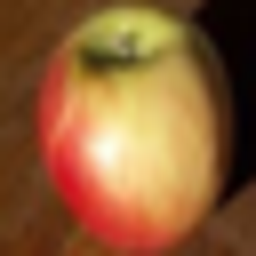

In [3]:
# Read training set (training data)
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')

# Read test sample (test data)
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Here indicate your classes by option!!!
# Reform the selection and leave only the 3 specified classes.
CLASSES = [0, 55, 58]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

## Creating a Pytorch DataLoader

Batch is the number of images (part of the dataset) on which the model is trained in one iteration.
Example:
Dataset - 1000 images. Butch - 100 images. This means that the entire data set will be trained in 10 iterations.

In [4]:
# Specify the batch size
batch_size = 128

dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # creating a dataset object
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # creating an instance of the DataLoader class
dataloader

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f0926ce3c50>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f0926ce3790>}

# Creating models

The creation of models is carried out using the nn module, while the most popular neural network blocks or layers are already implemented in the module, such as:
* fully connected words Linear
* Conv2d convolutional layer
* MaxPool2d pooling
* BatchNorm2d normalization
* many activation functions ReLU, Softmax, Tanh
* regularizer layers, for example Dropout

In this laboratory work, we will consider only 2 building blocks of a neural network from the above list, namely Linear and ReLU.

You can specify a model in 2 ways:

1. using nn.Sequential
2. using inheritance from the nn.Module class

The first method is suitable for creating simple models without branches. Essentially, they can be thought of as a conveyor belt, where the input tensor is passed to a series of sequential transformations to obtain the output tensor.

If it is necessary to use more complex architectures, where pipeline tracks can branch into several parts, then nn.Module is used. This approach allows you to implement a variety of architectures.

To create a simple multilayer perceptron with one hidden layer and a nonlinearity function, according to the first method, it is enough to write the following code:

     model = nn.Sequential(
       nn.Linear(input_dims, hidden_dims),
       nn.ReLU(),
       nn.Linear(hidden_dims, num_classes)
     )

To create a simple multilayer perceptron with one hidden layer and a nonlinearity function, according to the second method, you need to create a class and a model as an instance of this class:

     class MLP(nn.Module):
         def __init__(self, input_dims, hidden_dims, num_classes,
                      *args, **kwargs):
             super(MLP, self).__init__()
             self.fc1 = Linear(input_dims, hidden_dims)
             self.fc2 = Linear(hidden_dims, num_classes)
        
         def forward(self, input):
              x = self.fc1(input)
              x = F.relu(x)
              x = self.fc2(x)
              return x
    
     model = MLP(input_dims, hidden_dims, num_classes)

At the same time, it is possible to nest nn.Module and nn.Sequential inside other modules, which allows you to create very complex model architectures.

## Creating a Pytorch model of a multilayer perceptron with one hidden layer

In [5]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

# Let's create a simple multilayer perceptron with one hidden layer and a nonlinearity function.
# The number of hidden layers can be changed.
class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32*32*3, hidden_size), 
            nn.ReLU(), # activation function
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

HIDDEN_SIZE = 10
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

# Model training

Before training models, you need to select a loss function and optimizer. Various loss functions are also presented in the nn module:
* __nn.MSELoss__ - mean square error (y_true-y_pred)**2
* __nn.BCEWithLogitsLoss__ - binary cross entropy for binary classification problems
* __nn.CrossEntropyLoss__ - categorical cross entropy for multi-class classification problems

As an alternative, you can implement the loss function yourself, for example for MSELoss:

     inputs, y = batch
     ...
     output = model(inputs)
     loss = ((output - y)**2).sum()
     ...

Optimizers are contained in the __torch.optim__ module. There are many objective function optimizers, the classic one being Stochastic Gradient Descent or SGD. You must pass the weights of the model to the class constructor, as well as specify the learning step or learning rate.

## Selecting loss function and gradient descent optimizer

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
# lr - training step. This parameter can be changed.
optimizer = optim.SGD(model.parameters(), lr=0.005)

## Training the model by epoch

To put the model into the training state, you must call the __train__ method. After which the model is ready for training.

To train neural network models, gradient descent and its variations are used, which are based on the method of successive approximations.

In one epoch, we conditionally choose to pass the iterator through the entire data set; in one iteration, we choose to optimize the model parameters using the current mini-batch. PyTorch automatically calculates derivatives when calling the __backward__ method on a loss function.

In this case, when called again, the values of the new gradients will be added to the previous calculated ones. Therefore, to avoid unwanted effects, it is common practice to clear past gradient values at each iteration using the __zero_grad__ method applied to an instance of the optimizer class.

Epoch—traversal of all instances of a dataset.
Iteration is one learning step.
Overfitting – A model that performs well on training data but poorly on test data.

In [7]:
# Specify the number of epochs.
# Increasing the number of epochs leads to an increase in program running time.
# The more epochs we train, the more accurately the model is trained, but there is a risk of overfitting.

EPOCHS = 250
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
for epoch in range(EPOCHS):  # go through the data set several times
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # getting one minibatch; batch is a two-element list of [inputs, labels]
        inputs, labels = batch

        # clearing past gradients from the last iteration
        optimizer.zero_grad()

        # forward + backward passes + optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()

        # To update the parameters of the neural network, the step method is used, applied to an instance of the optimizer class.
        optimizer.step()

        # for calculating statistics
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    running_loss = 0.0

    # To put the model into the verification state, you must call the eval method. After which the model is ready for testing.
    model.eval()

    with torch.no_grad(): # disable automatic differentiation
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')
print('Обучение закончено')

[1,    12] loss: 0.980
[1,     3] val loss: 0.870
[2,    12] loss: 0.811
[2,     3] val loss: 0.774
[3,    12] loss: 0.736
[3,     3] val loss: 0.765
[4,    12] loss: 0.691
[4,     3] val loss: 0.700
[5,    12] loss: 0.657
[5,     3] val loss: 0.715
[6,    12] loss: 0.633
[6,     3] val loss: 0.663
[7,    12] loss: 0.612
[7,     3] val loss: 0.633
[8,    12] loss: 0.596
[8,     3] val loss: 0.652
[9,    12] loss: 0.580
[9,     3] val loss: 0.633
[10,    12] loss: 0.566
[10,     3] val loss: 0.633
[11,    12] loss: 0.554
[11,     3] val loss: 0.631
[12,    12] loss: 0.537
[12,     3] val loss: 0.655
[13,    12] loss: 0.528
[13,     3] val loss: 0.588
[14,    12] loss: 0.516
[14,     3] val loss: 0.604
[15,    12] loss: 0.502
[15,     3] val loss: 0.586
[16,    12] loss: 0.494
[16,     3] val loss: 0.595
[17,    12] loss: 0.487
[17,     3] val loss: 0.611
[18,    12] loss: 0.478
[18,     3] val loss: 0.559
[19,    12] loss: 0.468
[19,     3] val loss: 0.594
[20,    12] loss: 0.459
[20,  

## Checking the quality of the model by class on training and test samples

The output tensor of model predictions must be cut off from the computational graph. To do this, the **detach** method is used, applied to the output tensor of the model. Otherwise, memory leaks may occur. The **numpy** method converts a tensor to a multidimensional NumPy array.

By default, the model outputs so-called logits of classes, rather than their probabilities. To obtain probabilities, it is necessary to apply the activation function **Softmax**. However, in practice this is not necessary, since the value of the logits is consistent with the probability of the classes, and this step can be omitted to obtain the number of the most probable class. The class number is obtained using either the **argmax** method or the **argsort** method, the latter allowing metrics such as Accuracy@5 and quality metrics to be read.

**Quality metrics:**
– Precision – Percentage of positive marks that are correctly identified
   *Precision = (# true positives) / (# true positives + # false positives)*
– Recall – Percentage of positive examples that were correctly identified
   *Recall = (# true positives) / (# true positives + # false negatives)*
– Accuracy – Percentage of positive marks
   *Accuracy = (# true positives + # true negatives) / (# of samples)*

In [8]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # disable automatic differentiation
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        # We will display a report on the accuracy of model training.
        # The model can train up to 100% on test data. The result shown on the training set is worse.
        
        # We will display ranking metrics for the test and training samples.
        print(part)

        # Values are output to 4 decimal places.

        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

           0     0.9940    1.0000    0.9970       500
          55     1.0000    0.9900    0.9950       500
          58     0.9960    1.0000    0.9980       500

    accuracy                         0.9967      1500
   macro avg     0.9967    0.9967    0.9967      1500
weighted avg     0.9967    0.9967    0.9967      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

           0     0.8120    0.9500    0.8756       100
          55     0.7396    0.7100    0.7245       100
          58     0.7471    0.6500    0.6952       100

    accuracy                         0.7700       300
   macro avg     0.7662    0.7700    0.7651       300
weighted avg     0.7662    0.7700    0.7651       300

--------------------------------------------------


# Saving the model in ONNX

Let's consider two ways to save the model:


1. Saving parameters
2. Preservation of the entire architecture

In [9]:
# FIRST METHOD: saving parameters
PATH = 'cifar_lnn.pth'
torch.save(model.state_dict(), PATH)
# loading
new_model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
new_model.load_state_dict(torch.load(PATH))
new_model.eval()

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [10]:
# SECOND METHOD: saving the entire architecture
PATH2 = 'cifar_lnn.pt'
torch.save(model, PATH2)
# loading
new_model_2 = torch.load(PATH2)
new_model_2.eval()

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [ ]:
!pip install onnx

In [11]:
# input tensor for model
x = torch.randn(1, 32, 32, 3, requires_grad=True).to('cpu')
torch_out = model(x)

# export model
torch.onnx.export(model,               # model
                  x,                   # input tensor (or tuple of multiple tensors)
                  "cifar100_LNN.onnx", # where to save (either path to file or fileObject)
                  export_params=True,  # stores the weights of the trained parameters inside the model file
                  opset_version=9,     # ONNX version
                  do_constant_folding=True,  # whether to shorten constants for optimization
                  input_names = ['input'],   # input layer name
                  output_names = ['output'],  # output layer name
                  dynamic_axes={'input' : {0 : 'batch_size'},    # dynamic axes, in this case only the batch size
                                'output' : {0 : 'batch_size'}})

The model is saved in files with the .onnx extension. This file can be downloaded to your computer and used for further downloading and using the trained model.